<a href="https://colab.research.google.com/github/gihuni99/Pytorch_Study/blob/main/Ch5_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning(전이 학습)

Deep learning기반의 모델을 제대로 훈련시키기 위해서는 많은 양의 데이터가 필요하다. 하지만 충분히 큰 데이터셋을 확보하는 것은 돈과 시간이 많이 들기 때문에 쉽지 않다. 이것의 해결방법이 **Transfer Learning**이다. ImageNet과 같은 큰 데이터셋을 사용하여 훈련된 모델의 가중치를 가져와 목적에 맞게 보정하여 사용하는 것을 Transfer learning이라고 한다. Pre-trained Model을 사용하면 비교적 적은 수의 데이터를 통해 원하는 과제를 해결할 수 있다.

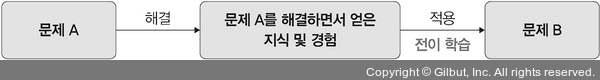

Transfer Learning을 위한 방법으로 **Feature Extractor**와 **Fine-tunning** 방법이 있다.

## 5.3.1 Feature Extractor(특성 추출 기법)

**Feature Extractor**는 ImageNet 데이터셋으로 pre-train된 모델을 가져와 마지막 Fully connected layer부분만 새롭게 구성한다.(FCN에서 image의 category를 결정) FCN만 학습하고 나머지 부분은 학습되지 않도록 한다.

- Convolutional layer: Data로부터 Feature를 추출(Feature Extractor)
- Data Classifier: 추출된 Feature를 입력으로 받아 이미지에 대한 클래스를 분류

따라서 pre-train된 모델의 Convolutional layer(weight고정)에 새로운 데이터를 통과시키고, 그 출력을 Data Classifier에서 training시킨다. 사용 가능한 image classification model은 다음과 같다.

• Xception

• Inception V3

• ResNet50

• VGG16

• VGG19

• MobileNet

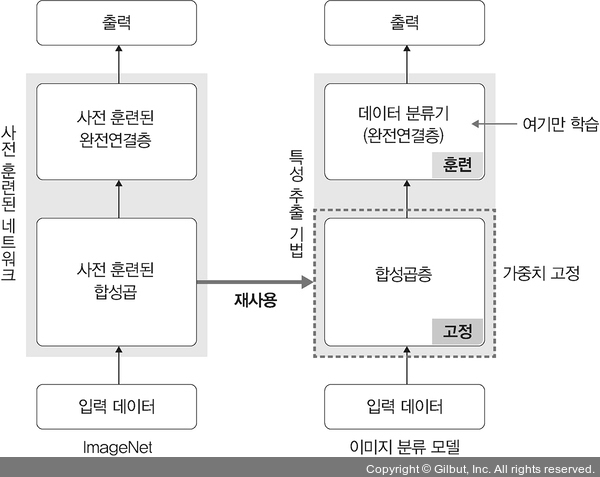

1. 필요한 라이브러리 호출

In [1]:
import os
import time
import copy
import glob
import cv2 #opencv library
import shutil

import torch
import torchvision #computer vision용도의 package
import torchvision.transforms as transforms # data preprocessing을 위한 package
import torchvision.models as models #pytorch network를 사용하기 위한 package
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

2. 예제에서 사용한 image data를 pre-processing

-----

Kaggle dataset불러오는 과정

In [2]:
!pip install kaggle --upgrade

In [5]:
from google.colab import files
files.upload()

KeyboardInterrupt: ignored

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!ls -1ha kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

In [ ]:
!unzip dogs-vs-cats.zip

In [ ]:
!unzip test1.zip
!unzip train.zip

---------------------

해당예제에서는 올려준 파일을 사용하겠다.

In [6]:
from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # 데이터 불러오기: chap05/data/catndog.zip 파일 선택

Saving catanddog (1).zip to catanddog (1).zip


In [7]:
!unzip catanddog.zip -d catanddog/

Archive:  catanddog.zip
   creating: catanddog/test/
   creating: catanddog/test/Cat/
  inflating: catanddog/test/Cat/8100.jpg  
  inflating: catanddog/test/Cat/8101.jpg  
  inflating: catanddog/test/Cat/8102.jpg  
  inflating: catanddog/test/Cat/8103.jpg  
  inflating: catanddog/test/Cat/8104.jpg  
  inflating: catanddog/test/Cat/8105.jpg  
  inflating: catanddog/test/Cat/8106.jpg  
  inflating: catanddog/test/Cat/8107.jpg  
  inflating: catanddog/test/Cat/8108.jpg  
  inflating: catanddog/test/Cat/8109.jpg  
  inflating: catanddog/test/Cat/8110.jpg  
  inflating: catanddog/test/Cat/8111.jpg  
  inflating: catanddog/test/Cat/8112.jpg  
  inflating: catanddog/test/Cat/8113.jpg  
  inflating: catanddog/test/Cat/8114.jpg  
  inflating: catanddog/test/Cat/8115.jpg  
  inflating: catanddog/test/Cat/8116.jpg  
  inflating: catanddog/test/Cat/8117.jpg  
  inflating: catanddog/test/Cat/8118.jpg  
  inflating: catanddog/test/Cat/8119.jpg  
  inflating: catanddog/test/Cat/8120.jpg  
  inflating

In [8]:
data_path='./catanddog/train' #데이터가 저장된 경로

transform=transforms.Compose( # 이미지 데이터를 변환하여 모델의 입력으로 사용할 수 있도록 함
    [
        transforms.Resize([256,256]),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor() #이미지 데이터를 Tensor로 변환
    ]
)
 #dataloader가 데이터를 불러올 대상(또는 경로)과 방법(preprocessing)을 정의
train_dataset=torchvision.datasets.ImageFolder(data_path,transform=transform)
#ImageFolder를 할당하고, batch_size, shuffle여부 등을 결정
train_loader=torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,#데이터를 불러올 때, 사용할 하위 프로세스 개수
    shuffle=True
)

print(len(train_dataset))

385


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


+) 한가지 몰랐던 점

ImageFolder는 폴더명을 **label(정답)**으로 인식한다. 순서대로(0, 1, 2, ...)로 불러온다. 아래와 같은 형태이다.

    data_path/
        class1/
            image1.jpg
            image2.jpg
            ...
        class2/
            image1.jpg
            image2.jpg
            ...
        ...

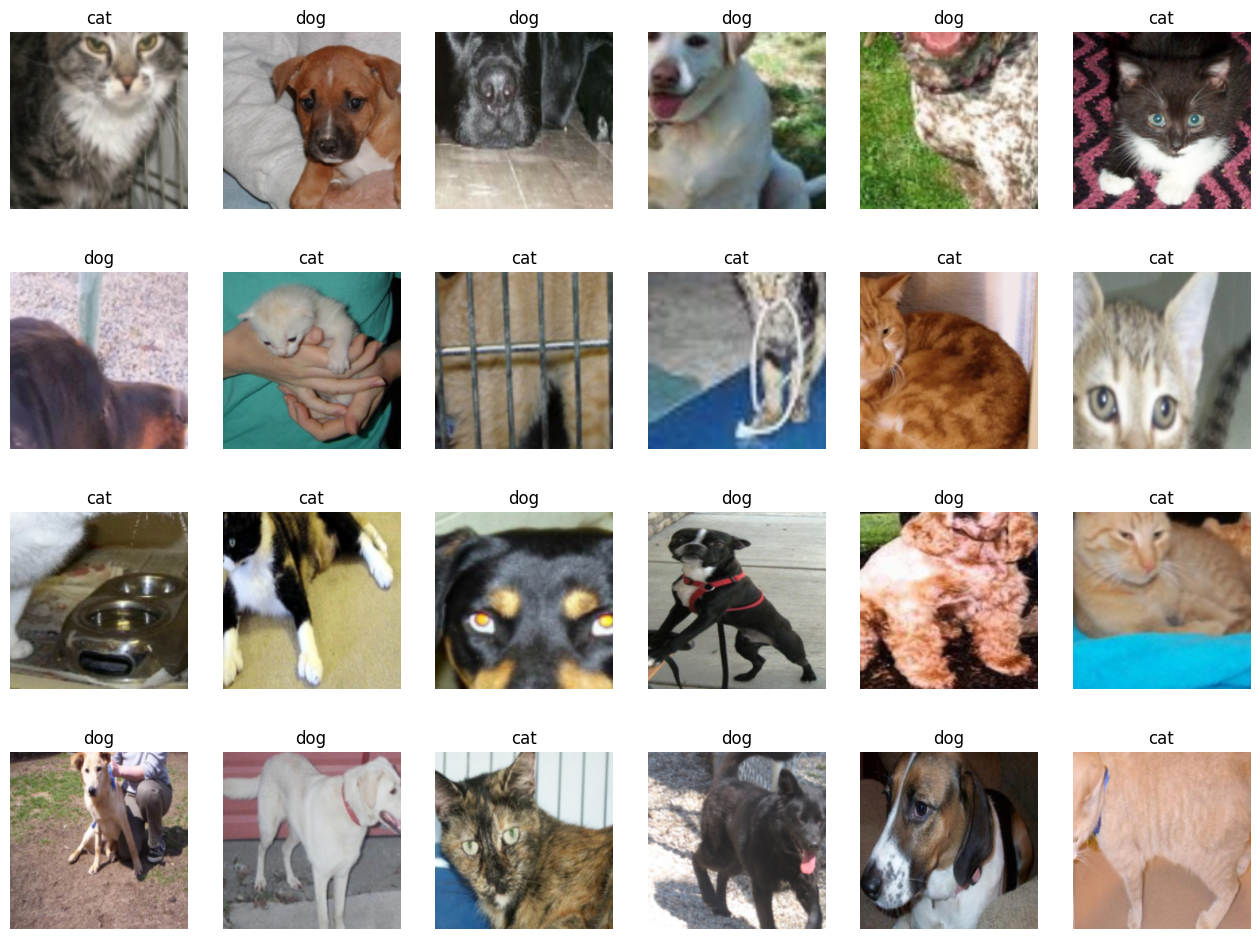

In [9]:
import numpy as np
#iterator를 사용하기 위해 iter()와 next()가 필요하다.
#samples,labels=iter(train_loader).next() 최신 pytorch에서 이렇게 사용하지 않는다
data_iter = iter(train_loader)
samples, labels = next(data_iter) #하나의 batch(32)단위 데이터를 불러온다.(즉, samples,labels안에는 32개의 data가 들어있다.)
classes={0:'cat',1:'dog'}
fig=plt.figure(figsize=(16,24)) #새로운 그림을 생성하는 함수 호출(가로 16, 세로 24 inch)
for i in range(24):
    a=fig.add_subplot(4,6,i+1)# 4x6 격자 형태의 서브플롯(subplot)생성, i+1은 subplot의 인덱스값
    a.set_title(classes[labels[i].item()]) #label데이터에서 변수값(0 또는 1)만을 가져오고, class 딕셔너리를 통해 class이름을 title로 설정
    a.axis('off') #x, y축을 표시하지 않고, 이미지만 나타낸다.
    #pytorch tensor는 image가 (CxHxW)로 되어있지만, Matplotlib의 imshow는 (HxWxC)로 입력되어야 하므로 np.transpose를 통해 차원 변환
    a.imshow(np.transpose(samples[i].numpy(),(1,2,0)))#현재 mini-batch에서 i번째 data를 표시
plt.subplots_adjust(bottom=0.2,top=0.6,hspace=0) #subplot들의 위치 및 간격을 조정

+) iterator(반복자)는 순서대로 다음값을 반환할 수 있는 객체, 즉 **next**method를 사용할 수 있다.

iterable한 객체는 요소를 하나씩 반환할 수 있는 객체를 말한다.(list, tuple 등 for문으로 반환 가능한 값들)

따라서 위 예제에서는 iter()와 next를 사용하여 iterable한 DataLoader의 반환값을 iterator로 만들어준것이다.

In [10]:
#np.transpose()
print(samples.shape) #batch하나의 크기
print(samples[1].shape) #batch내에서 1개의 data의 크기
p=np.transpose(samples[1].numpy(),(1,2,0)) #matplolib의 imshow를 사용하기 위한 변환
print(p.shape)#np.transpose를 통해 차원 변환 후 크기

torch.Size([32, 3, 224, 224])
torch.Size([3, 224, 224])
(224, 224, 3)


위에서 data가 모두 준비되었으므로 pretrained ResNet18모델을 불러오자.

In [67]:
resnet18=models.resnet18(pretrained=True)

불러온 ResNet18의 Convolutional layer를 사용하지만, parameter에 대해서는 학습하지 않도록 고정(freeze)시킨다.

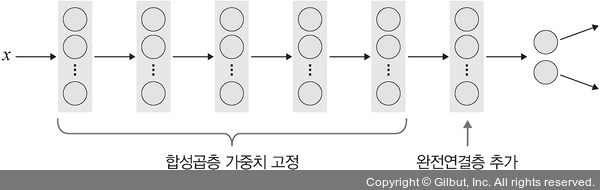

In [68]:
def set_parameter_requires_grad(model,feature_extracting=True):
    if feature_extracting:
        for param in model.parameters(): #model.parameters()를 통해 parameter들을 하나씩 불러온다.
            param.requires_grad=False #required_grad=False로 설정하여 학습되지 않도록 고정한다.
set_parameter_requires_grad(resnet18)

이제 마지막으로 ResNet18의 FC layer를 추가한다(binary classification을 수행)

In [69]:
#resnet18.fc는 resnet18의 FC layer를 의미
resnet18.fc=nn.Linear(512,2) #512는 FC layer의 input차원, 2는 output차원

param.requires_grad가 True인 값, 즉 학습 가능한 FC layer의 파라미터들을 print찍어보면 아래와 같다.

In [70]:
for name,param in resnet18.named_parameters():
    if param.requires_grad:
        print('name:',name,'/data:',param.data)

name: fc.weight /data: tensor([[ 0.0099,  0.0340,  0.0292,  ...,  0.0397, -0.0191,  0.0128],
        [ 0.0381, -0.0113,  0.0061,  ...,  0.0014, -0.0304, -0.0157]])
name: fc.bias /data: tensor([-0.0393, -0.0140])


위처럼 FC layer는 학습가능하도록 하고, Feature Extractor는 고정시키는 과정을 보았는데, 이제 실제로 사용해보기 위한 코드를 작성해보자.

In [71]:
model=models.resnet18(pretrained=True) #모델 객체 생성

for param in model.parameters():#모델의 convolutional layer weight고정
    param.requires_grad=False

model.fc=torch.nn.Linear(512,2)
for param in model.fc.parameters(): #FC layer는 학습
    param.requires_grad=True

optimizer=torch.optim.Adam(model.fc.parameters()) #optimizer가 fc layer의 weight를 찾아갈 수 있도록
cost=torch.nn.CrossEntropyLoss() #Loss Function
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

위에서 모델이 준비가 되었고, 이제 학습을 위한 함수를 생성해보자.

In [72]:
 def train_model(model,
                 dataloaders,
                 criterion,
                 optimizer,
                 device,
                 num_epochs=13,
                 is_train=True
                 ):
     since=time.time() #컴퓨터의 현재시각을 구하는 함수
     acc_history=[] #Acc를 저장하는 list
     loss_history=[] #Loss를 저장하는 list
     best_acc=0.0 #Best accuracy를 저장하는 변수

     for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1)) #epoch을 나타내기 위해 print
        print('-'*10)

        running_loss=0.0
        running_corrects=0

        for inputs, labels in dataloaders:
            inputs=inputs.to(device)#input(image data)을 GPU로 보낸다.
            labels=labels.to(device)

            model.to(device) #모델과 데이터는 같은 위치에 있어야함(GPU)
            optimizer.zero_grad() #gradient를 0으로 설정
            outputs=model(inputs) #forward propagation(데이터에 대한 예측), output은 각 클래스일 확률을 나타낸다.
            loss=criterion(outputs,labels) #outputs이 음수가 나오더라도, cross entory loss는 softmax를 적용하여 괜찮다.

            #max(outpts,1)은 dim=1을 따라 최대값을 반환한다.
            #이 때 max값과 max값의 index값 두개를 반환하기 때문에 '_,preds'를 통해 index값, 즉 class에 대한 정보만 저장한다.
            _,preds=torch.max(outputs,1)

            loss.backward()#back propagation(미분을 통해 Loss function에 끼친 영향력(변화량)을 구한다.)
            optimizer.step()#Loss function을 최적화하도록 parameter값들을 조정한다.

            #Tensor.size(0)는 0차원의 크기를 의미, 예제에서 BS=32이므로 32xCxHxW이고, size(0)는 32이다.
            running_loss+=loss.item()*inputs.size(0) #loss가 32개의 image에 대한 loss이므로 bs만큼 곱하여 running loss에 저장
            running_corrects+=torch.sum(preds==labels.data) #labels의 data와 일치하면 1, 다르면 0을 더한다.

        epoch_loss=running_loss/len(dataloaders.dataset) #epoch이 끝난 후 data의 전체 길이를 나누어 평균 오차를 계산
        epoch_acc=running_corrects.double()/len(dataloaders.dataset) #평균 정확도 계산

        print('Loss:{:.4f} Acc:{:.4f}'.format(epoch_loss,epoch_acc)) #{index순서(지정하지 않아도 순서대로):문자길이와 형식}

        if epoch_acc > best_acc:
            best_acc=epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(),os.path.join('./my_ckpt/','{0:0=2d}.pth'.format(epoch))) #checkpoint 파일 저장

        print()

     time_elapsed=time.time()-since #실행 시간(학습시간) 계산
     print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60,time_elapsed%60))
     print('Best Acc: {:4f}'.format(best_acc))
     return acc_history,loss_history

위처럼 training code를 완성하였다. 이제 직접 학습시켜보자

In [73]:
params_to_update=[]
for name,param in model.named_parameters():
    if param.requires_grad==True:
        params_to_update.append(param) #parameter학습 결과를 저장
        print("\t",name)

optimizer=optim.Adam(params_to_update) #학습 결과를 optimizer에 전달

	 fc.weight
	 fc.bias


위 결과를 통해 fc layer들의 parameter만이 학습된다는 것을 알 수 있다. 이제 모델을 학습시켜보자.

In [74]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion=nn.CrossEntropyLoss()
train_acc_hist,train_loss_hist=train_model(model,train_loader,criterion,optimizer,device)#resnet18은 이전에 만든 model

Epoch 0/12
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Loss:0.5743 Acc:0.6857

Epoch 1/12
----------
Loss:0.3762 Acc:0.8416

Epoch 2/12
----------
Loss:0.3174 Acc:0.8545

Epoch 3/12
----------
Loss:0.2587 Acc:0.8935

Epoch 4/12
----------
Loss:0.2533 Acc:0.9065

Epoch 5/12
----------
Loss:0.2895 Acc:0.8545

Epoch 6/12
----------
Loss:0.2878 Acc:0.8727

Epoch 7/12
----------
Loss:0.2395 Acc:0.8883

Epoch 8/12
----------
Loss:0.2635 Acc:0.9013

Epoch 9/12
----------
Loss:0.2480 Acc:0.8857

Epoch 10/12
----------
Loss:0.1860 Acc:0.9325

Epoch 11/12
----------
Loss:0.1450 Acc:0.9662

Epoch 12/12
----------
Loss:0.1689 Acc:0.9351

Training complete in 0m 34s
Best Acc: 0.966234


96%의 정확도를 보여준다. 이제 test set을 사용하여 모델의 정확도를 평가해보자.

In [75]:
test_path='./catanddog/test'

transform=transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

test_dataset=torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader=torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


위 코드를 통해 test_loader를 코딩하였고, test dataset이 98개임을 알 수 있었다. 이제 Evaluation을 위한 코드를 작성해보자.

In [87]:
def eval_model(model,dataloaders,device):
    since=time.time()
    acc_history=[]
    best_acc=0.0

    #glob는 디렉토리에서 원하는 파일들을 추출할 때 사용
    saved_models=glob.glob('./my_ckpt/'+'*.pth') # .pth확장자를 갖는 파일들을 불러온다.
    saved_models.sort() #불러온 pth파일들을 정렬
    print('saved_model',saved_models)

    for model_path in saved_models:
        print('Loading model',model_path)

        #torch.load는 pth파일을 불러오고, load_state_dict를 통해 model에 파라미터를 전달한다.
        model.load_state_dict(torch.load(model_path))
        model.eval() #model을 evaluation mode로 전환
        model.to(device)
        running_corrects=0

        for inputs,labels in dataloaders:
            inputs=inputs.to(device)
            labels=labels.to(device)

            #autograd를 사용하지 않는다는 의미로 with torch.no_grad()를 사용
            #eval과정이기 때문에 forward propagation을 할 필요가 없다.
            with torch.no_grad():
                outputs=model(inputs)

            _,preds=torch.max(outputs.data,1)
            #내 생각에는 이미 preds는 index값이기 때문에 아래 코드는 필요없을 것 같다.
            #preds[preds>=0,5]=1
            #preds[preds<0.5]=0

            #preds.eq(labels)은 preds배열과 labels가 일치하는지 검사하는 용도로 사용한다.
            #sum()을 통해 일치하는 label의 개수를 더한다.
            running_corrects+=preds.eq(labels).int().sum()

        epoch_acc=running_corrects.double()/len(dataloaders.dataset)
        print('Acc:{:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc=epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed=time.time()-since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed//60,time_elapsed%60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history

위에 test를 위한 함수를 작성하였고, 이제 실제로 평가해보자.

In [88]:
val_acc_hist=eval_model(model,test_loader,device)

saved_model ['./my_ckpt/00.pth', './my_ckpt/01.pth', './my_ckpt/02.pth', './my_ckpt/03.pth', './my_ckpt/04.pth', './my_ckpt/05.pth', './my_ckpt/06.pth', './my_ckpt/07.pth', './my_ckpt/08.pth', './my_ckpt/09.pth', './my_ckpt/10.pth', './my_ckpt/11.pth', './my_ckpt/12.pth']
Loading model ./my_ckpt/00.pth
Acc:0.9388

Loading model ./my_ckpt/01.pth
Acc:0.8980

Loading model ./my_ckpt/02.pth
Acc:0.9490

Loading model ./my_ckpt/03.pth
Acc:0.9388

Loading model ./my_ckpt/04.pth
Acc:0.9286

Loading model ./my_ckpt/05.pth
Acc:0.9490

Loading model ./my_ckpt/06.pth
Acc:0.9286

Loading model ./my_ckpt/07.pth
Acc:0.9388

Loading model ./my_ckpt/08.pth
Acc:0.9694

Loading model ./my_ckpt/09.pth
Acc:0.9184

Loading model ./my_ckpt/10.pth
Acc:0.9388

Loading model ./my_ckpt/11.pth
Acc:0.9694

Loading model ./my_ckpt/12.pth
Acc:0.9388

Validation complete in 0m 8s
Best Acc: 0.969388


위 결과를 보면 96%의 정확도를 보인다. 이제 matpolib 라이브러리를 통해 결과를 그래프로 확인해보자.

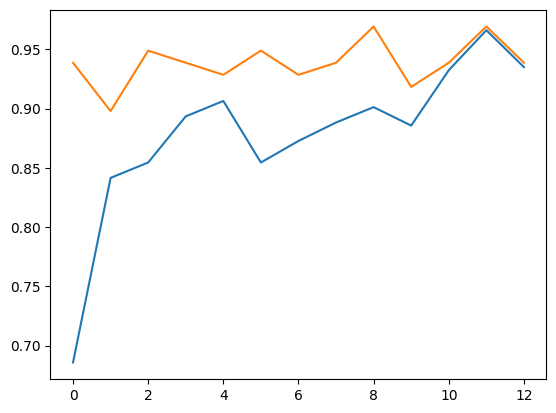

In [89]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

다음은 train dataset에 대해 epoch이 진행될 떄마다 오차를 출력한 결과이다. 오차가 점점 줄어드는 것으로 보아 학습이 잘되었다고 볼 수 있다.

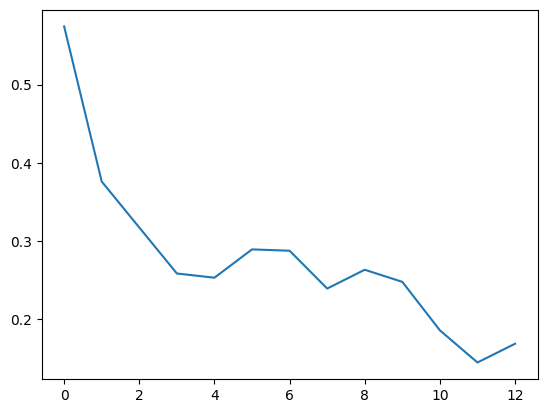

In [90]:
plt.plot(train_loss_hist)
plt.show()

Acc와 Loss 외에도, 실제 데이터를 잘 예측하는지 살펴보자.

먼저 예측된 이미지를 출력하기 위한 pre-processing 함수를 생성한다.

In [99]:
def im_convert(tensor):
    #clone()은 기존 tensor의 내용을 복사한 tensor를 생성하는 의미
    #pytorch는 tensor의 모든 연산을 기록하는데(Computational graph)
    #detach()를 사용하여 전파가 이루어지지 않는 객체를 만들 수 있다.
    image=tensor.clone().detach().numpy()
    image=image.transpose(1,2,0)
    image=image*(np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))) #왜 이런 코드가 있는지 모르겠다..
    image=image.clip(0,1) #image데이터를 0~1사이의 값으로 제한할 때 사용
    return image

+) **Computational Graph**

계산 그래프란 계산 과정을 그래프로 나타낸 것

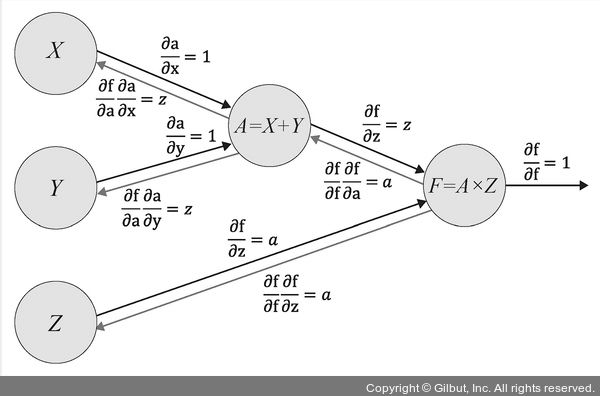

계산 그래프를 사용하는 이유는 두 가지이다.

• 국소적 계산이 가능. 국소적 계산이 가능하다는 의미는 그림 5-39에서 Z 값이 변경되었다면 X, Y 계산 결과를 그대로 유지한 채로 바뀐 Z의 연산이 필요한 F=A×Z만 계산하면 된다.

• 역전파를 통한 미분 계산이 편리. 그림 5-39의 주황색 선이 역전파를 구하는 과정을 보여 주는데 연쇄 법칙(chain rule)을 이용하여 빠르고 간편하게 미분을 계산할 수 있다.

+) **Chain Rule**

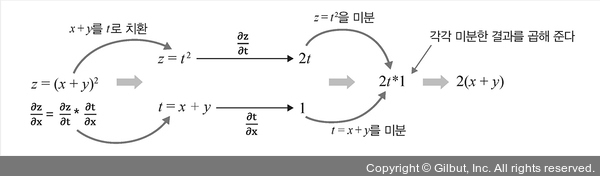

이제 test dataset을 통해 실제로 잘 분류하는지 확인해보자.

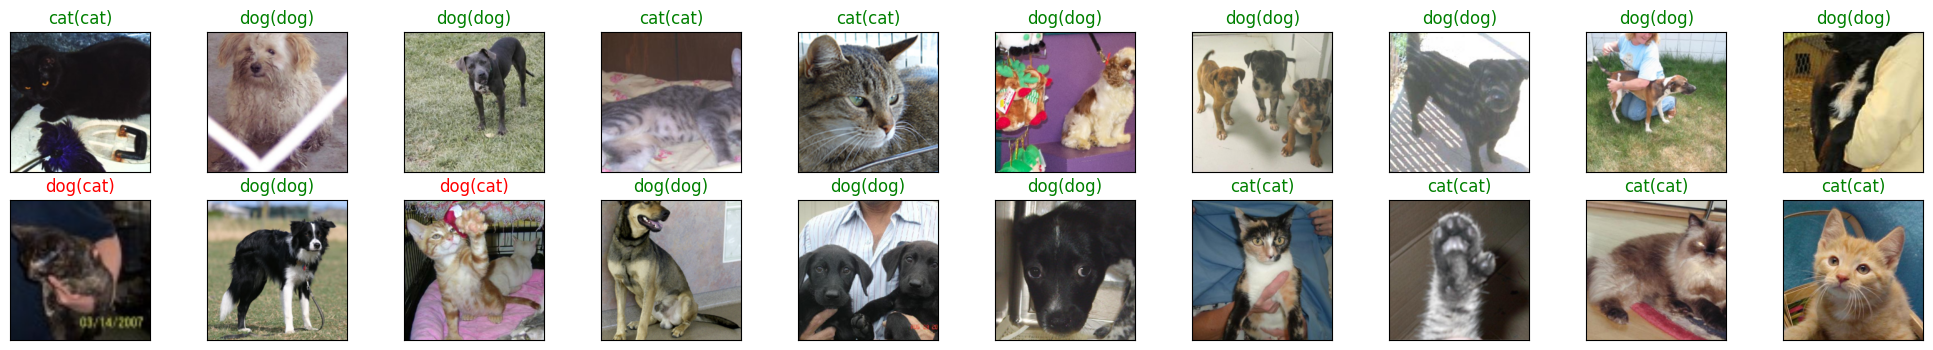

<Figure size 640x480 with 0 Axes>

In [105]:
classes = {0:'cat', 1:'dog'}

dataiter = iter(test_loader)
images, labels = next(dataiter)
output = model(images)
_, preds = torch.max(output, 1)

fig=plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
    plt.imshow(im_convert(images[idx]))
    a.set_title(classes[labels[idx].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].
             item()])), color=("green" if preds[idx]==labels[idx] else "red"))
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)


## Fine-tuning

**Fine-tuning**은 Feature Extraction에서 더 나아가 pre-train된 모델의 convolutional layer와 classifier의 weight를 업데이트하여 훈련하는 방식이다. Feature extraction은 특성 추출의 성능이 좋다는 전제하에 좋은 성능을 낼 수 있다. 하지만 특성이 잘못 추출되었다면(ImageNet의 물건의 특징이 적용 대상과 다름) fine-tuning을 통해 weight를 update해서 목적에 맞게 다시 학습시킬 수 있다.

즉 fine-tuning은 pre-train된 모델을 미세하게 조정하여 분석하려는 데이터셋에 맞도록 모델의 파라미터를 수정하는 것이다.

fine-tuning은 train dataset의 크기와 pre-trained model에 따라 다른 전략을 세울 수 있다.

• **데이터셋이 크고 사전 훈련된 모델과 유사성이 작을 경우**: 모델 전체를 재학습. 데이터셋 크기가 크기 때문에 재학습시키는 것이 좋은 전략이다.

• **데이터셋이 크고 사전 훈련된 모델과 유사성이 클 경우**: 합성곱층의 뒷부분(완전연결층과 가까운 부분)과 데이터 분류기를 학습. 데이터셋이 유사하기 때문에 전체를 학습시키는 것보다는 강한 특징이 나타나는 합성곱층의 뒷부분과 데이터 분류기만 새로 학습하더라도 최적의 성능을 낼 수 있다.

• **데이터셋이 작고 사전 훈련된 모델과 유사성이 작을 경우**: 합성곱층의 일부분과 데이터 분류기를 학습. 데이터가 적기 때문에 일부 계층에 미세 조정 기법을 적용한다고 해도 효과가 없을 수 있다. 따라서 합성곱층 중 어디까지 새로 학습시켜야 할지 적절하게 설정해주어야 한다.

• **데이터셋이 작고 사전 훈련된 모델과 유사성이 클 경우**: 데이터 분류기만 학습. 데이터가 적기 때문에 많은 계층에 미세 조정 기법을 적용하면 과적합이 발생할 수 있다. 따라서 최종 데이터 분류기인 완전연결층에 대해서만 미세 조정 기법을 적용한다.

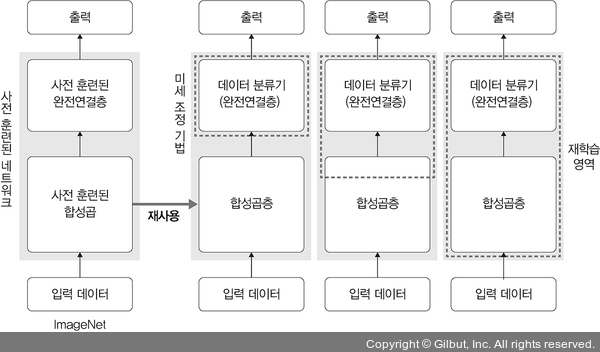